In [1]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

C:\Users\Conor\Anaconda3\python.exe
3.6.8 |Anaconda custom (64-bit)| (default, Feb 21 2019, 18:30:04) [MSC v.1916 64 bit (AMD64)]
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

# Home-PC

In [4]:
import os.path

file_place = r"C:\Users\Conor\DataSets"

Breast_DF = pd.read_pickle(os.path.join(file_place,"Breast_mie_corrected"))

In [ ]:
import os.path

file_place = r"C:\Users\Conor\DataSets"

Breast_DF = pd.read_pickle(os.path.join(file_place,"Breast_data_raw"))

Remove blood and Necrosis from the dataset

In [ ]:
indices = (Breast_DF.reset_index().Label != "Blood") & (Breast_DF.reset_index().Label != "Necrosis") & (Breast_DF.reset_index().Label != "Non_malignant Epithelium") & (Breast_DF.reset_index().Label != "Malignant Epithelium")

Breast_DF = Breast_DF[indices.values]#.head()

In [41]:
indices = (Breast_DF.reset_index().Label != "Blood") & (Breast_DF.reset_index().Label != "Necrosis")
Breast_DF = Breast_DF[indices.values]#.head()

# Preprocessing

Preprocessing method, maybe make this all one pipe?

In [42]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, RobustScaler

steps = [
         #("Normalise", Normalizer(norm = "l1"))
         ("RobustScaler", RobustScaler())
        ]

pipe  = Pipeline(steps)

In [43]:
import Tissue_Analysis_Tools as TAT

PCA_NR_Components = 20

dataframe = TAT.process_data(Breast_DF, paraffin = (1340,1490))#, balance = "Type")

PCA_reduced = TAT.PCA_denoise(dataframe, PCA_NR_Components)

values = pipe.fit_transform(PCA_reduced.T).T

Breast_DF_P = pd.DataFrame(values, index = dataframe.index, columns = dataframe.columns)

Processing


C:\Users\Conor\AppData\Roaming\Python\Python36\site-packages\pandas\core\frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# Analysis

# Dataset partitioning

In [69]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

lb = LabelBinarizer()

DATA = Breast_DF_P#.sample(10000)

DATA = DATA.sample(frac = 1) # Shuffle the dataframe randomly

y_label = "Label"

X = DATA
Y = DATA.reset_index()[y_label]
lb.fit(Y)

Y_b = pd.DataFrame(lb.transform(Y), index = Y.index)

# split set by patients
train_p, valid_p = train_test_split(np.unique(Breast_DF_P.reset_index()["Core"])
                                    , test_size = 0.2
                                    #, random_state = 42
                                    , shuffle = True)

# Keep a separate validation set aside 
#X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)

# Training and validation sets on patient basis
X_train = X[X.reset_index()["Core"].isin(train_p).values]
X_valid = X[X.reset_index()["Core"].isin(valid_p).values]

y_train = X_train.reset_index()[y_label]
y_valid = X_valid.reset_index()[y_label]

#pd.DataFrame(X_valid.values, index = y_valid.values).round(6).to_csv(r"E:\Validation.csv".format(i+1), header = None)

print("Train set: \n", y_train.value_counts(), "\n")
print("Validation set: \n", y_valid.value_counts(), "\n")

# Create dataframes containing the binary labels for each class
y_train = pd.DataFrame(lb.transform(y_train), index = y_train.index)
y_valid = pd.DataFrame(lb.transform(y_valid), index = y_valid.index)

if len(np.unique(Y)) == 2: y_train[1] = y_train[0].map({0:1, 1:0})
if len(np.unique(Y)) == 2: y_valid[1] = y_valid[0].map({0:1, 1:0})

Train set: 
 Malignant Epithelium        115676
Malignant Stroma             56468
Non_malignant Stroma         36585
Non_malignant Epithelium     29165
Name: Label, dtype: int64 

Validation set: 
 Malignant Epithelium        30449
Malignant Stroma            15428
Non_malignant Stroma         2830
Non_malignant Epithelium     2567
Name: Label, dtype: int64 



In [36]:
DATA.reset_index().Stage.value_counts()

IIa     172381
-        71147
IIb      33709
I        17733
IIIb     14402
IIIa     12162
Name: Stage, dtype: int64

In [11]:
y_label

for name in np.unique(DATA.reset_index()[y_label]):
    print(name, "\n")
    index = DATA.reset_index()[y_label] == DATA.reset_index()[y_label].value_counts()[name]
    index = DATA.reset_index()[y_label] == name

    print(DATA[index.values].reset_index()["Core"].value_counts())

- 

M12    9308
M15    7843
M4     6652
M9     6008
M16    5922
M1     5397
M3     5172
M14    5136
M8     5112
M7     4963
M11    4784
M10    4537
M2      313
Name: Core, dtype: int64
I 

E13    4949
F12    3249
B5     1823
A8     1739
B15    1646
A4     1498
F6     1448
A11    1381
Name: Core, dtype: int64
IIIa 

J4     3308
J7     2854
B16    2512
L1     1797
E3     1691
Name: Core, dtype: int64
IIIb 

J11    9402
K1     2459
E5     1847
C3      694
Name: Core, dtype: int64
IIa 

J9     15704
A3     13722
K6     10663
D16     8989
F15     8188
B4      7575
L3      7317
J6      7294
A6      7084
J15     5602
B11     5433
J14     5432
J3      5060
A7      4425
B2      4214
G5      4154
L2      4000
B1      3615
K5      3600
J13     3578
B14     3541
F2      3486
K7      3373
A2      3337
D7      3328
D15     3258
A1      2906
A5      2530
B10     2496
E6      2403
D13     1859
A9      1816
K3      1598
B7       801
Name: Core, dtype: int64
IIb 

H3     12779
B6      9577
J5      4518


In [75]:
for name in np.unique(DATA.reset_index().Stage):
    print(name, "\n")
    index = DATA.reset_index().Stage == DATA.reset_index().Stage.value_counts()[name]
    index = DATA.reset_index().Stage == name

    print(DATA[index.values].reset_index()["Core"].value_counts())

[autoreload of pkg_resources.extern.six failed: Traceback (most recent call last):
  File "C:\Users\Conor\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Conor\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 378, in superreload
    module = reload(module)
  File "C:\Users\Conor\Anaconda3\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "C:\Users\Conor\Anaconda3\lib\importlib\__init__.py", line 147, in reload
    raise ImportError(msg.format(name), name=name)
ImportError: module pkg_resources._vendor.six not in sys.modules
]
[autoreload of pkg_resources.extern.appdirs failed: Traceback (most recent call last):
  File "C:\Users\Conor\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\Conor\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line

- 

M12    9308
M15    7843
M4     6652
M9     6008
M16    5922
M1     5397
M3     5172
M14    5136
M8     5112
M7     4963
M11    4784
M10    4537
M2      313
Name: Core, dtype: int64
I 

E13    4949
F12    3249
B5     1823
A8     1739
B15    1646
A4     1498
F6     1448
A11    1381
Name: Core, dtype: int64
IIIa 

J4     3308
J7     2854
B16    2512
L1     1797
E3     1691
Name: Core, dtype: int64
IIIb 

J11    9402
K1     2459
E5     1847
C3      694
Name: Core, dtype: int64
IIa 

J9     11571
K6     10663
F15     7770
L3      7317
J6      7294
A6      7084
J15     5602
B11     5433
J14     5432
J3      5060
A7      4425
B2      4214
B4      4190
G5      4154
L2      4000
A3      3989
B1      3615
K5      3600
J13     3578
B14     3541
F2      3486
D7      3328
D15     3258
A2      3151
A1      2906
K7      2643
A5      2530
B10     2496
E6      2403
D13     1859
A9      1816
B7       801
Name: Core, dtype: int64
IIb 

H3     12779
B6      7731
J5      4518
E4      1747
F9      1588


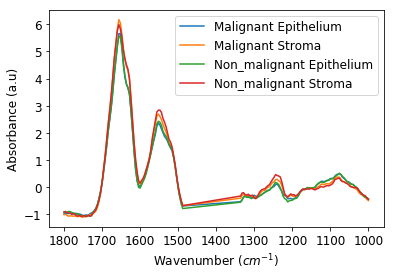

In [70]:
plt.clf()

for name, df in Breast_DF_P.groupby(level = y_label):
    
    plt.plot(df.mean(axis = 0), label = name)

plt.ylabel("Absorbance (a.u)")
plt.xlabel("Wavenumber $(cm^{-1})$")
plt.gca().invert_xaxis()
plt.legend()
plt.show()

In [ ]:
index = DATA.reset_index().Label == DATA.reset_index().Label.value_counts().idxmin()

print(len(DATA[index.values].reset_index()["Core"].value_counts()))

# HyperOpt Training - XGBoost

In [71]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

This will ouput a score for the current hyperparameter configuration 

In [72]:
from sklearn.metrics import f1_score, confusion_matrix

def j_xg_bin(y_predicted, dtrain_true):
    
    y_true = dtrain_true.get_label().astype(int)
    bin_preds = [1 if pred >0.5 else 0 for pred in y_predicted]
    
    #print(y_true)

    tn, fp, fn, tp = confusion_matrix(y_true, bin_preds).ravel()
    
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    j = sens + spec - 1
        
    return "J", 1-j # Return inverse as this score will be minimised

def j_normal_bin(y_true, y_pred):
    
    bin_preds = [1 if pred >0.5 else 0 for pred in y_pred]
    
    tn, fp, fn, tp = confusion_matrix(y_true, bin_preds).ravel()
    
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    j = sens + spec - 1
    
    return j

In [73]:
import xgboost as xgb

def hyper_opt_search_XGBoost(X, y, grouping, weight_binary = False
                             , optimiser = tpe.suggest, random_state = 42
                             , cores = 1, n_evals = 3, k_splits = 2):
    
    from sklearn.model_selection import train_test_split, GroupKFold
    from sklearn.metrics import roc_auc_score
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    def score(params):
        
        loss_cv = []
        scores = []
        
        i = 0
        
        for train_index, test_index in GroupKFold(k_splits).split(X, y, grouping):
            
            # Uncomment to save folds
            #X_Data = np.vstack([X[train_index], X[test_index]])
            #Y_Data = lb.inverse_transform(np.hstack([y[train_index], y[test_index]]))
            #pd.DataFrame(X_Data, index=Y_Data).round(6).to_csv(r"F:\fold_{}.csv".format(i+1), header = None)

            dtrain = xgb.DMatrix(X[train_index], label=y[train_index])
            dtest = xgb.DMatrix(X[test_index], label=y[test_index])

            watchlist = [(dtest, 'eval'), (dtrain, 'train')]

            xgb_cl = xgb.train(params, dtrain, evals=watchlist, verbose_eval=False)

            predictions = xgb_cl.predict(dtest, ntree_limit = xgb_cl.best_iteration + 1)

            # TODO: try and get the y_labels from dtest
            # score = roc_auc_score(y[test_index, predictions])
            score = j_normal(y[test_index], predictions)
            scores.append(score)
            
            loss = 1 - score
            
            loss_cv.append(loss)
            
        #print("\tScore {0}\n\n".format(1-loss))
        return {'loss': loss.mean(), 'status': STATUS_OK, 'scores': scores}
    
    space = {
        "early_stopping_round" : 10,
        "n_classes" : 2,
        "scale_pos_weight" : 1/(np.sum(y)/y.shape[0]),
        'n_estimators': hp.quniform('n_estimators', 10, 1000, 1),
        'learning_rate': hp.quniform('learning_rate', 0.025, 0.7, 0.025),
        # A problem with max_depth casted to float instead of int with
        # the hp.quniform method.
        'max_depth':  hp.choice('max_depth', np.arange(3, 15, dtype=int)),
        'min_child_weight': hp.quniform('min_child_weight', 1, 8, 1),
        'subsample': hp.quniform('subsample', 0.3, 1, 0.05),
        'gamma': hp.quniform('gamma', 0.3, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 0.95, 0.05),
        'eval_metric': 'auc',
        #'eval_metric': j_xg,
        'objective': 'binary:logistic',
        # Increase this number if you have more cores. Otherwise, remove it and it will default 
        # to the maxium number. 
        'nthread': cores,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
        'seed': random_state      
    }

    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=n_evals)
    
    best["scale_pos_weight"] = space["scale_pos_weight"]
    best["n_estimators"] = int(best["n_estimators"])

    return best

from sklearn.model_selection import KFold

grouping = X_train.reset_index()["Core"]

indices = []

i = 0

for train_index, test_index in KFold(5).split(grouping):
    
    indices.append(train_index)

    # Uncomment to save folds
    X_Data = np.vstack(X_train.values[test_index])
    Y_Data = lb.inverse_transform(np.hstack(y_train[0][test_index]))
    output = pd.DataFrame(X_Data, index=Y_Data)
    output.round(6).to_csv(r"F:\fold_{}.csv".format(i+1), header = None)
    
    print(output.index.value_counts())

    i = i+1

In [74]:
%time
from sklearn.model_selection import train_test_split, GroupKFold, LeaveOneGroupOut

xgbinary_classifiers = dict()

for i, name in enumerate(np.unique(Y)):
    
    print("\n{}: {}".format(i + 1, name))
    
    best_hyperparams = hyper_opt_search_XGBoost(X_train.values,
                                        y_train[i].values,
                                        X_train.reset_index()["Core"],
                                        weight_binary = True,
                                        optimiser = tpe.suggest,
                                        random_state = 42,
                                        cores = -1,
                                        n_evals = 20,
                                        k_splits = 5)
                                #, trials = Trials())
    
    ## TODO: append best classifier to dictionary, store any other
    ## relevant variables with it using trials.
    clf_xgb = xgb.XGBClassifier()
    
    # Set the parameters which are best for that particular class
    clf_xgb.set_params(**best_hyperparams)
    clf_xgb.fit(X_train.values, y_train[i])

    xgbinary_classifiers[name] = clf_xgb
    
    #if len(np.unique(Y)) == 2: break

Wall time: 0 ns

1: Malignant Epithelium
100%|███████████████████████████████████████████████| 20/20 [1:02:25<00:00, 217.66s/it, best loss: 0.36609312684974116]

2: Malignant Stroma
100%|██████████████████████████████████████████████████| 20/20 [59:14<00:00, 189.50s/it, best loss: 0.5145190767988144]

3: Non_malignant Epithelium
100%|██████████████████████████████████████████████████| 20/20 [56:21<00:00, 158.76s/it, best loss: 0.5434773641124657]

4: Non_malignant Stroma
100%|██████████████████████████████████████████████████| 20/20 [53:06<00:00, 153.40s/it, best loss: 0.6284892498436851]


In [77]:
from sklearn.metrics import confusion_matrix, roc_auc_score

In [78]:
def bin_predict(x_array, classifiers):
    
    content = {name: classifier.predict_proba(x_array)[:,1] for name, classifier in classifiers.items()}
    output = pd.DataFrame(content)
    
    # Normalise probability
    output = output.div(output.sum(axis = 1), axis = 0)

    return output

NameError: name 'binary_classifiers' is not defined

# Results

In [80]:
probs = bin_predict(X_valid.values, xgbinary_classifiers)

aucs = pd.Series({class_name: roc_auc_score(y_valid.iloc[:,i], probs.iloc[:,i]) for i, class_name in enumerate(probs.columns)}, name = "AUC")

results = pd.DataFrame(sens_spec_etc(lb.inverse_transform(y_valid.values), probs.idxmax(axis = 1))).append(aucs)#, ignore_index = True)

NameError: name 'sens_spec_etc' is not defined

In [104]:
from sklearn.metrics import confusion_matrix

def sens_spec_etc(y_true, y_pred):
    
    assert len(np.unique(y_true)) == len(np.unique(y_pred)), "True and predicted labels have different classes present"

    output = dict()
    
    for i, name in enumerate(np.unique(y_true)):
        
        stats = dict()
        #todo add assert statement to ensure at least 1 example of each class
        
        conf_mat = confusion_matrix(y_true, y_pred)

        stats["TP"] = conf_mat[i,i].round(2)
        stats["FP"] = np.sum(conf_mat[:,i]) - stats["TP"]
        stats["FN"] = np.sum(conf_mat[i,:]) - stats["TP"]
        stats["TN"] = np.sum(conf_mat) - stats["TP"] - stats["FP"] - stats["FN"]
        
        stats["Sensitivity"] = stats["TP"]/(stats["TP"] + stats["FN"])
        stats["Specficity"] = stats["TN"]/(stats["TN"] + stats["FP"])
        stats["F1"] = 2*stats["TP"]/(2*stats["TP"] + stats["FN"] + stats["FP"])
        stats["J"] = stats["Sensitivity"] + stats["Specficity"] - 1
        
        output[name] = stats
        
    return pd.DataFrame(output)
    
    

In [105]:
sens_spec_etc(lb.inverse_transform(y_valid.values), probs.idxmax(axis = 1))

,Malignant Epithelium,Malignant Stroma,Non_malignant Epithelium,Non_malignant Stroma
F1,0.803346,0.693638,0.316804,0.429421
FN,7977.000000,6041.000000,644.000000,1242.000000
FP,3025.000000,2251.000000,7650.000000,2978.000000
J,0.592763,0.545643,0.592062,0.499658
Sensitivity,0.738021,0.608439,0.749123,0.561131
Specficity,0.854742,0.937204,0.842938,0.938527
TN,17800.000000,33595.000000,41057.000000,45466.000000
TP,22472.000000,9387.000000,1923.000000,1588.000000


In [332]:
import itertools

def conf_mat_analyse(conf_mat, column_title, labels):
    
    stats = dict()
    stats = []
    
    n_classes = conf_mat.shape[0]
    
    for i, name in enumerate(labels):
        #todo add assert statement to ensure at least 1 example of each class

        TP = conf_mat[i,i]
        FP = np.sum(conf_mat[:,i]) - TP
        FN = np.sum(conf_mat[i,:]) - TP
        TN = np.sum(conf_mat) - TP - FP - FN

        stats.append([name,TP,TN,FP,FN])
        
    df = pd.DataFrame(stats, columns = [column_title,"TP","TN","FP","FN"])
    
    df["Acc"] = df.apply(lambda row: (row["TP"] + row["TN"])/(row["TP"] + row["TN"] + row["FP"] + row["FN"])*100, axis = 1)

    try: df["Sens"] = df.apply(lambda row: row["TP"]/(row["TP"] + row["FN"])*100, axis = 1)
        
    except: df["Sens"] = np.nan # Outputs NaN where there are no positive cases
        
    df["Spec"] = df.apply(lambda row: row["TN"]/(row["TN"] + row["FP"])*100, axis = 1)
    
    return df

In [83]:
lb.inverse_transform(y_valid.values)

array(['Non_malignant Epithelium', 'Malignant Epithelium',
       'Malignant Epithelium', ..., 'Malignant Epithelium',
       'Malignant Stroma', 'Malignant Stroma'], dtype='<U24')

In [ ]:
results

In [ ]:
import matplotlib as mpl

print(mpl.get_configdir())
plt.style.reload_library()
plt.style.use('ScanCan_Style')

In [ ]:
fig, axes = plt.subplots(nrows = len(xgbinary_classifiers), ncols = 1, figsize = (25,len(binary_classifiers)*10))

#fig.suptitle("Relative wavenumber importances", fontsize = 16)

for title, plot, ax in zip(xgbinary_classifiers.keys(), xgbinary_classifiers.values(), axes.flatten()):
    
    ax.grid()
    ax.bar(X.columns, plot.feature_importances_, width = 5)
    #ax.set_xlim(min(X.columns), max(X.columns))
    ax.set_title(title)
    ax.invert_xaxis()
    ax.set_xlabel("Wavenumber $(cm^{-1})$")
    
plt.show()
fig.savefig(r"C:\Users\Conor\Google Drive\PhD\Breast_Cancer_Analysis_April\Feature_Importances_XGBoost.svg"
           ,format = "svg"
           ,bbox_inches = "tight")

# Hyperopt on other classifiers

In [ ]:
def hyper_opt_search(clf, space, X, y, grouping, optimiser = tpe.suggest, random_state = 42, cores = 2, n_evals = 3):

    from sklearn.model_selection import train_test_split, GroupKFold
    from sklearn.metrics import roc_auc_score, confusion_matrix
    
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    def score(params):
        
        loss_cv = []
        
        for train_index, test_index in GroupKFold(5).split(X, y, grouping):

            X_train, Y_train = X[train_index], y[train_index]
            X_test, Y_test = X[test_index], y[test_index]
            
            clf.fit(X_train, Y_train)

            predictions = clf.predict_proba(X_test)
            
            #score = roc_auc_score(y[test_index], predictions[:,1])
            score = j_normal(y[test_index], predictions[:,1])

            loss = 1 - score
            
            loss_cv.append(loss)
            
        #print("\tScore {0}\n\n".format(1-loss))
        return {'loss': loss.mean(), 'status': STATUS_OK}
    
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                # trials=trials, 
                max_evals=n_evals)
    return best

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

classifiers = {
    "SVM": (SVC(probability = True, kernel = "linear", class_weight = "balanced", gamma = "auto"), 
            {'C': hp.loguniform("C", np.log(1e-5), np.log(1e5))
            })
    
    ,"KNN": (KNeighborsClassifier(),
            {'n_neighbors': hp.choice('n_neighbors', np.arange(2, 30, dtype=int))
            ,'leaf_size': hp.choice('leaf_size', np.arange(10,60, dtype = int))
            ,'n_jobs': -1})
    
    ,"RF": (RandomForestClassifier(),
            {'n_estimators ': hp.choice('n_estimators', np.arange(10,1000,5))
            ,'max_depth': hp.choice('max_depth', np.arange(1,30,1))
            ,'min_samples_split': hp.quniform('min_samples_split', 0.3, 1, 0.05)})
    
    ,"LDA": (LinearDiscriminantAnalysis(solver = "lsqr"),
            {'eigen': hp.choice('shrinkage', [None, "auto"])})
    
    ,"LR": (LogisticRegression(class_weight = "balanced", n_jobs = -1),
            {'C': hp.loguniform("C", np.log(1e-5), np.log(1e5))})
}

In [ ]:
%time
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.base import clone

# Dictionary to store the best classifier after optimisation
classifier_results = dict()

for clf_name, clf_u, params in zip(classifiers.keys(), list(zip(*classifiers.values()))[0], list(zip(*classifiers.values()))[1]):

    # Dictionary to store the binary classifier for each class
    binary_classifiers = dict()
    
    if clf_name in ["KNN", "SVM", "RF"] : continue

    for i, name in enumerate(np.unique(Y)):
        
        clf = clone(clf_u)
        print("\n{}".format(name))

        best_hyperparams = hyper_opt_search(clf,
                                            params,
                                            X_train.values,
                                            y_train[i].values,
                                            X_train.reset_index()["Core"],
                                            optimiser = tpe.suggest,
                                            random_state = 42,
                                            cores = -1,
                                            n_evals = 20)

        ## TODO: append best classifier to dictionary, store any other
        ## relevant variables with it. Use trials.

        # Set the parameters which are best for that particular class
        clf = clf.set_params(**best_hyperparams)
        
        clf.fit(X_train.values, y_train[i])
        
        binary_classifiers[name] = clf
        
    classifier_results[clf_name] = binary_classifiers

In [ ]:
classifier_results.keys()

In [ ]:
o_probs = bin_predict(X_valid.values, classifier_results["LDA"])

aucs = pd.Series({class_name: roc_auc_score(y_valid.iloc[:,i], o_probs.iloc[:,i]) for i, class_name in enumerate(o_probs.columns)}, name = "AUC")

results = pd.DataFrame(sens_spec_etc(lb.inverse_transform(y_valid.values), o_probs.idxmax(axis = 1))).append(aucs)#, ignore_index = True)

In [ ]:
results

In [ ]:
def plot_importances(bin_classifiers, n_best = None):

    fig, axes = plt.subplots(nrows = len(bin_classifiers), ncols = 1, figsize = (25,len(bin_classifiers)*10))

    #fig.suptitle("Relative wavenumber importances", fontsize = 16)

    for title, clf, ax in zip(bin_classifiers.keys(), bin_classifiers.values(), axes.flatten()):

        importances = pd.Series(abs(clf.coef_.reshape(164)), index = X_train.columns)

        if n_best != None:
            importances = importances.sort_values().iloc[:n_best]

        ax.grid()
        ax.bar(importances.index, importances.values, width = 5)

        ticks = np.arange(min(X_train.columns), max(X_train.columns), 100)
        ax.set_xlim(min(X.columns), max(X.columns))
        ax.set_title(title)
        ax.invert_xaxis()
        ax.set_xlabel("Wavenumber $(cm^{-1})$")
        ax.set_xticks = ticks

    return fig

In [ ]:
for clf_name in ["LDA", "LR"]:
    
    fig = plot_importances(classifier_results[clf_name], n_best = None)

    fig.savefig(r"C:\Users\Conor\Google Drive\PhD\Breast_Cancer_Analysis_April\Feature_Importances_{}.svg".format(clf_name)
               ,format = "svg"
               ,bbox_inches = "tight")

This function is used to optimise the hyperparameters of XGboost

# Importing Breast Cancer data

In [ ]:
from sklearn.preprocessing import normalize

def import_image(original):
    
    image = original.reshape(original.shape[-1], -1)

    return normalize(image, axis = 0, norm = "l1").reshape(original.shape)

In [ ]:
import os
from scipy.io import loadmat

file_place = r"B:\Breast Cancer Data\br20832_cores\br20832_cores"
file_list = os.listdir(file_place)

image_list_directory = r"B:\Breast Cancer Data\overlay\overlay"
image_list = os.listdir(image_list_directory)

images = {file_name[:-4] : import_image(loadmat(os.path.join(file_place, file_name))["image"]) for file_name in file_list[:3]}

In [ ]:
import os
from scipy.io import loadmat

file_place = "/mnt/hgfs/E/Breast Cancer Data/br20832_cores/br20832_cores"
file_list = os.listdir(file_place)

image_list_directory = "/mnt/hgfs/E/Breast Cancer Data/overlay/overlay"
image_list = os.listdir(image_list_directory)

images = {file_name[:-4] : import_image(loadmat(os.path.join(file_place, file_name))["image"]) for file_name in file_list[:3]}

In [ ]:
import os
from scipy.io import loadmat
import imageio

file_place = r"E:\Breast Cancer Data\br20832_cores\br20832_cores"
file_list = os.listdir(file_place)

image_list_directory = r"E:\Breast Cancer Data\overlay\overlay"
image_list = os.listdir(image_list_directory)

#overlays = {image_list[:-4] : imageio.imread(os.path.join(image_list_directory, image_name)) for image_name in image_list}

images = {file_name[:-4] : loadmat(os.path.join(file_place, file_name))["image"] for file_name in file_list[-20:-10]}

In [ ]:
images.keys()

# Preprocess image

In [ ]:
image_ref = "L5"

image = images[image_ref]
#overlay = 

PCA_NR_Components = 5

image_dataframe = pd.DataFrame(image.reshape(-1, image.shape[-1]), columns = Breast_DF_Mie.columns)

dataframe = TAT.process_data(image_dataframe, paraffin = (1340,1490))

PCA_reduced = TAT.PCA_denoise(dataframe, PCA_NR_Components)

values = pipe.fit_transform(PCA_reduced.T).T

image_P_list = pd.DataFrame(values, index = dataframe.index, columns = dataframe.columns)

image_P = image_P_list.values.reshape(image.shape[0], image.shape[1], -1)

# Plotting predictions for image

In [ ]:
fig, axes = plt.subplots(ncols = len(binary_classifiers), nrows = 1, figsize = (15,10))

pred_cube = individual_predictions(image_P, binary_classifiers)

for ax, name, image in zip(axes.flat, pred_cube.keys(), pred_cube.values()):
    
    ax.set_title(name)
    ax.imshow(image)
    
plt.show()

In [ ]:
import matplotlib as mpl

def individual_predictions(image, classifiers):
    
    Pred_cube = {name: classifier.predict_proba(image.reshape(-1, image.shape[-1]))[:,1].reshape(image.shape[0], image.shape[1]) for name, classifier in classifiers.items()}
    
    return Pred_cube

def prediction_plot(image, classifiers, **kwargs):
    
    # Get colours from tab10 colour list
    colours = dict(zip(classifiers.keys(), plt.get_cmap("tab10").colors))
    
    # Prediction values for each 
    Pred_DF = pd.DataFrame({name: classifier.predict_proba(image.reshape(-1, image.shape[-1]))[:,1] for name, classifier in classifiers.items()})

    Pred_DF["Winner_ID"] = Pred_DF.idxmax(axis = 1)
    Pred_DF["Winner_conf"] = Pred_DF.max(axis = 1)

    # RGB image
    RGB = np.array([colours[ID] for ID in Pred_DF["Winner_ID"]]).reshape(image.shape[0], image.shape[1], 3)
    
    # Confidence plot
    conf = Pred_DF["Winner_conf"].values.reshape(image.shape[0], image.shape[1], 1)
    
    # RGBA plot
    rgba = np.concatenate([RGB,conf], axis = 2)
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', list(colours.values()), N = len(colours))
    
    # If a threshold is supplied, use it
    if "thresh" in kwargs.keys():
        rgba[np.abs(image_P.mean(axis = 2)) < kwargs.get("thresh")] = [0,0,0,0]
        
    fig, ax = plt.subplots()
    cax = ax.imshow(rgba, cmap = cmap)
    cbar = fig.colorbar(cax, ticks = np.linspace(0, 1, len(classifiers)))
    cbar.ax.set_yticklabels(classifiers.keys())  # horizontal colorbar
    
    return rgba, conf.reshape(conf.shape[0],conf.shape[1])

In [ ]:
from skimage.filters import threshold_otsu

In [ ]:
rgba, conf = prediction_plot(image_P, classifier_results["LDA"], thresh = threshold_otsu(image_P.mean(axis = 2)))

In [ ]:
rgba, conf = prediction_plot(image_P, classifier_results["LR"], thresh = threshold_otsu(image_P.mean(axis = 2)))

In [ ]:
rgba, conf = prediction_plot(image_P, xgbinary_classifiers, thresh = threshold_otsu(image_P.mean(axis = 2)))